In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import C3XGate
# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit import BasicAer, Aer,execute
import mplhep
plt.style.use(mplhep.style.LHCb2)  # CMS or ATLAS/LHCb

In [2]:
    #1.249   1/10  9/10
    #1.1071   2/10  8/10
    #0.99116   3/10  7/10
    #0.88608   4/10  6/10
    #0.7854   5/10
    #0.68472   6/10  4/10
    #0.57964   7/10  3/10
    #0.46365   8/10  2/10
    #0.32175   9/10  1/10
    #0         10/10  0
COS_1 = 1.249
COS_2 = 1.1071
COS_3 = 0.99116
COS_4 = 0.88608
COS_5 = 0.7854
COS_6 = 0.68472
COS_7 = 0.57964
COS_8 = 0.46365
COS_9 = 0.32175
COS_10 = 0


In [2]:
import pandas as pd
filename = "weight_real.xlsx"
df = pd.read_excel(filename, header=None,
	index_col=None,
	engine='openpyxl')
print(df)


          0          1          2          3          4          5    \
0    7.961062   8.685934   0.571989   2.490247   9.416495   2.688694   
1    3.188427   3.241027   5.555809   8.947206   0.221181   7.566279   
2    2.679106   2.442817   7.442758   0.800638   6.533028   3.381809   
3    2.625122   5.394424   0.695302   0.164385   4.802693   3.671401   
4    6.152483   4.994080   1.599735   7.933554   4.209112   0.743685   
5    3.860707   2.075778   6.084689   0.636671   0.515639   1.785042   
6    3.755174   9.594178   3.449449   6.821409   5.731377   7.469820   
7    3.517097   2.253563   3.173034   5.245288   1.565625   6.348609   
8    5.065188   8.674208   6.373464   7.055747   4.526762   5.556688   
9   19.178734  22.354223   8.545188  17.479548  18.152368   8.989066   
10  15.338866  13.015274   9.829711   8.372206  11.497758  10.822344   
11  10.878738  17.309660  12.624574  16.167338   9.550637  16.794368   
12  10.804308  14.910983  15.089947  16.405286   6.468197  16.82

In [3]:
df.index = ['a1', 'a2', 'a3', 'b1', 'b2', 'b3', 'c1', 'c2', 'c3', '000110', '001001', '010010', '011000', '100001', '100100']

In [4]:
def cal_angle(df, step):
    angle_arr = []
    weight = 0
    for i in range(9):
        weight = df[step][i]
        angle_arr.append(math.acos(math.sqrt(float(weight/10))))
        
    return angle_arr

In [5]:
cal_angle(df, 0)

[0.4684972492588887,
 0.9707731338101663,
 1.0267517945042066,
 1.032866284856147,
 0.6691041337402857,
 0.9003371150328817,
 0.911204014421782,
 0.9359532410208002,
 0.7788791704699946]

In [6]:
def solution(df, step):
    solution_arr = []
    origin = df[step][9:]
    solution_arr = sorted(origin, reverse = True)
    return solution_arr

In [7]:
def initialize_s(qc, n_qubit, num_matching):
    """Apply a H-gate to 'qubits' in qc"""
    qc.x(n_qubit - 1)
    qc.h(n_qubit - 1)
    for q in range(num_matching):
        qc.h(q)
    #qc.reset(num_qubit)
    #qc.h(num_qubit)
    qc.barrier(list(range(n_qubit-1)))
    return qc

In [8]:
def violate_state(qc, n_qubit):
    #qc = QuantumCircuit(10)
    qc.barrier(list(range(n_qubit-1)))
    qc.ccx(0, 1, 6)
    qc.ccx(2, 3, 7)
    qc.ccx(4, 5, 8)
    qc.x([6, 7, 8])
    qc.append(C3XGate(), [6, 7, 8, 9])
    qc.x([6, 7, 8])
    qc.ccx(4, 5, 8)
    qc.ccx(2, 3, 7)
    qc.ccx(0, 1, 6)
    #oracle_violate = qc.to_gate()
    #oracle_violate.name = "violate"
    #qc.draw()
    return qc

In [9]:
def compare_node1_node2(qc, n_qubit):
    #qc = QuantumCircuit(11)
    
    qc.barrier(list(range(n_qubit-1)))
    qc.cx(0, 2)
    qc.barrier(0)
    qc.cx(1, 3)
    qc.barrier([0, 1])
    qc.cx(2, 6)
    qc.barrier([0, 1, 2])
    qc.cx(3, 7)
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.x([6, 7])
    qc.ccx(6, 7, 10)
    qc.x([6, 7])
    qc.barrier([0, 1, 2])
    qc.cx(3, 7)
    qc.barrier([0, 1])
    qc.cx(2, 6)
    qc.barrier([0])
    qc.cx(1, 3)
    qc.cx(0, 2)
    #oracle_edge12 = qc.to_gate()
    #oracle_edge12.name = "edge12"
    #qc.draw()
    return qc

In [10]:
def compare_node2_node3(qc, n_qubit):
    #qc = QuantumCircuit(13)
    
    qc.barrier(list(range(n_qubit-1)))
    qc.cx(2, 4)
    qc.barrier([0, 1])
    qc.cx(3, 5)
    qc.barrier([0, 1, 2])
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3, 4])
    qc.x([6, 7])
    qc.ccx(6, 7, 12)
    qc.x([6, 7])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3, 4])
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(3, 5)
    qc.barrier([0, 1, 2])
    qc.cx(2, 4)
    qc.barrier([0, 1])
    #oracle_edge23 = qc.to_gate()
    #oracle_edge23.name = "edge23"
    #qc.draw()
    return qc

In [11]:
def compare_node1_node3(qc, n_qubit):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))
    qc.cx(0, 4)
    qc.barrier([0])
    qc.cx(1, 5)
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.x([6, 7])
    qc.ccx(6, 7, 11)
    qc.x([6, 7])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3])
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(1, 5)
    qc.barrier([0])
    qc.cx(0, 4)
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [12]:
def diffuser(qc, nqubits, n_qubit):
    qc.barrier(list(range(n_qubit-1)))
    #qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    qc.barrier(list(range(nqubits-1)))
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    #U_s = qc.to_gate()
    #U_s.name = "diffuser"
    return qc

In [13]:
def rotate_a1(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([0, 1])
    qc.ccx(0, 1, 13)
    qc.cry(angle, 13, 14)
    qc.ccx(0, 1, 13)
    qc.x([0, 1])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [14]:
def rotate_a2(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([1])
    qc.ccx(0, 1, 13)
    qc.cry(angle, 13, 14)
    qc.ccx(0, 1, 13)
    qc.x([1])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [15]:
def rotate_a3(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([0])
    qc.ccx(0, 1, 13)
    qc.cry(angle, 13, 14)
    qc.ccx(0, 1, 13)
    qc.x([0])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [16]:
def rotate_b1(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([2, 3])
    qc.ccx(2, 3, 13)
    qc.cry(angle, 13, 15)
    qc.ccx(2, 3, 13)
    qc.x([2, 3])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [17]:
def rotate_b2(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([3])
    qc.ccx(2, 3, 13)
    qc.cry(angle, 13, 15)
    qc.ccx(2, 3, 13)
    qc.x([3])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [18]:
def rotate_b3(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([2])
    qc.ccx(2, 3, 13)
    qc.cry(angle, 13, 15)
    qc.ccx(2, 3, 13)
    qc.x([2])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [19]:
def rotate_c1(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([4, 5])
    qc.ccx(4, 5, 13)
    qc.cry(angle, 13, 16)
    qc.ccx(4, 5, 13)
    qc.x([4, 5])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [20]:
def rotate_c2(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([5])
    qc.ccx(4, 5, 13)
    qc.cry(angle, 13, 16)
    qc.ccx(4, 5, 13)
    qc.x([5])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [21]:
def rotate_c3(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([4])
    qc.ccx(4, 5, 13)
    qc.cry(angle, 13, 16)
    qc.ccx(4, 5, 13)
    qc.x([4])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [22]:
def match_weight_angle(grover_circuit, n_qubit, step, weight_df):
    weight_arr = weight_df[step]
    for i in range(9):
        angle = 0
        if (weight_arr[i] == 1):
            angle = COS_1
        elif (weight_arr[i] == 2):
            angle = COS_2
        elif (weight_arr[i] == 3):
            angle = COS_3
        elif (weight_arr[i] == 4):
            angle = COS_4
        elif (weight_arr[i] == 5):
            angle = COS_5
        elif (weight_arr[i] == 6):
            angle = COS_6
        elif (weight_arr[i] == 7):
            angle = COS_7
        elif (weight_arr[i] == 8):
            angle = COS_8
        elif (weight_arr[i] == 9):
            angle = COS_9
        elif (weight_arr[i] == 10):
            angle = COS_10

        if (i == 0):
            grover_circuit = rotate_a1(grover_circuit, n_qubit, angle)
        elif (i == 1):
            grover_circuit = rotate_a2(grover_circuit, n_qubit, angle)
        elif (i == 2):
            grover_circuit = rotate_a3(grover_circuit, n_qubit, angle)
        elif (i == 3):
            grover_circuit = rotate_b1(grover_circuit, n_qubit, angle)
        elif (i == 4):
            grover_circuit = rotate_b2(grover_circuit, n_qubit, angle)
        elif (i == 5):
            grover_circuit = rotate_b3(grover_circuit, n_qubit, angle)
        elif (i == 6):
            grover_circuit = rotate_c1(grover_circuit, n_qubit, angle)
        elif (i == 7):
            grover_circuit = rotate_c2(grover_circuit, n_qubit, angle)
        elif (i == 8):
            grover_circuit = rotate_c3(grover_circuit, n_qubit, angle)
    
    return grover_circuit
        

    

In [23]:
def match_weight_angle_reverse(grover_circuit, n_qubit, step, weight_df):
    weight_arr = weight_df[step]
    for i in range(9):
        angle = 0
        if (weight_arr[8-i] == 1):
            angle = COS_1
        elif (weight_arr[8-i] == 2):
            angle = COS_2
        elif (weight_arr[8-i] == 3):
            angle = COS_3
        elif (weight_arr[8-i] == 4):
            angle = COS_4
        elif (weight_arr[8-i] == 5):
            angle = COS_5
        elif (weight_arr[8-i] == 6):
            angle = COS_6
        elif (weight_arr[8-i] == 7):
            angle = COS_7
        elif (weight_arr[8-i] == 8):
            angle = COS_8
        elif (weight_arr[8-i] == 9):
            angle = COS_9
        elif (weight_arr[8-i] == 10):
            angle = COS_10

        if (i == 8):
            grover_circuit = rotate_a1(grover_circuit, n_qubit, angle * (-1))
        elif (i == 7):
            grover_circuit = rotate_a2(grover_circuit, n_qubit, angle * (-1))
        elif (i == 6):
            grover_circuit = rotate_a3(grover_circuit, n_qubit, angle * (-1))
        elif (i == 5):
            grover_circuit = rotate_b1(grover_circuit, n_qubit, angle * (-1))
        elif (i == 4):
            grover_circuit = rotate_b2(grover_circuit, n_qubit, angle * (-1))
        elif (i == 3):
            grover_circuit = rotate_b3(grover_circuit, n_qubit, angle * (-1))
        elif (i == 2):
            grover_circuit = rotate_c1(grover_circuit, n_qubit, angle * (-1))
        elif (i == 1):
            grover_circuit = rotate_c2(grover_circuit, n_qubit, angle * (-1))
        elif (i == 0):
            grover_circuit = rotate_c3(grover_circuit, n_qubit, angle * (-1))
    
    return grover_circuit
        

    

In [24]:
def compare(sim, sol, df, step):
    deviation = 0
    result = (step, deviation, True)
    for i in range (1):
        tmp = sim[i]
        c = tmp[:2]
        b = tmp[2:4]
        a = tmp[4:6]
        #print(a, b, c)
        if (a == '00'):
            a_weight = df[step][0]
        elif (a == '01'):
            a_weight = df[step][1]
        elif (a == '10'):
            a_weight = df[step][2]
        else:
            a_weight = 0

        if (b == '00'):
            b_weight = df[step][3]
        elif (b == '01'):
            b_weight = df[step][4]
        elif (b == '10'):
            b_weight = df[step][5]
        else: 
            b_weight = 0

        if (c == '00'):
            c_weight = df[step][6]
        elif (c == '01'):
            c_weight = df[step][7]
        elif (c == '10'):
            c_weight = df[step][8]
        else: 
            c_weight = 0

        #print(a_weight, b_weight, c_weight)
        weight_sum = a_weight + b_weight + c_weight
        
        if (weight_sum != sol[i]):
            print(weight_sum, sol[i])
            deviation = abs(weight_sum - sol[i])
            result = (step, deviation, False)

    return result    

    

In [25]:
def compare_real(sim, sol, df, step):
    deviation = 0
    result = (step, deviation)
    for i in range (1):
        tmp = sim[i]
        c = tmp[:2]
        b = tmp[2:4]
        a = tmp[4:6]
        #print(a, b, c)
        if (a == '00'):
            a_weight = df[step][0]
        elif (a == '01'):
            a_weight = df[step][1]
        elif (a == '10'):
            a_weight = df[step][2]
        else:
            a_weight = 0

        if (b == '00'):
            b_weight = df[step][3]
        elif (b == '01'):
            b_weight = df[step][4]
        elif (b == '10'):
            b_weight = df[step][5]
        else: 
            b_weight = 0

        if (c == '00'):
            c_weight = df[step][6]
        elif (c == '01'):
            c_weight = df[step][7]
        elif (c == '10'):
            c_weight = df[step][8]
        else: 
            c_weight = 0

        #print(a_weight, b_weight, c_weight)
        weight_sum = a_weight + b_weight + c_weight
        print(weight_sum, sol[i])
        deviation = abs(weight_sum - sol[i])
        
        result = (step, deviation)

    return result    

    

In [ ]:
def quantization(weight_df, i):
    

In [31]:
result_dir = 'result_real.xlsx'
result_df = pd.DataFrame(index = ['step', 'deviation'])

In [41]:
weight_df = df
#df.shape[1]
err = 0 
result_arr = [] 
for i in range (df.shape[1]):
    angle = []
    n_qubit = 18
    n_matching = 6
    grover_circuit = QuantumCircuit(n_qubit, n_matching)
    #grover_circuit_quantization = QuantumCircuit(n_qubit, n_matching)
    grover_circuit.reset(range(0, 18))
    #grover_circuit_quantization.reset(range(0, 18))
    grover_circuit = initialize_s(grover_circuit, n_qubit, n_matching)
    grover_circuit.x([14, 15, 16])
    angle = cal_angle(weight_df, i)
    grover_circuit = rotate_a1(grover_circuit, n_qubit, angle[0]) # 6
    grover_circuit = rotate_a2(grover_circuit, n_qubit, angle[1])  #
    grover_circuit = rotate_a3(grover_circuit, n_qubit, angle[2])
    grover_circuit = rotate_b1(grover_circuit, n_qubit, angle[3])
    grover_circuit = rotate_b2(grover_circuit, n_qubit, angle[4])
    grover_circuit = rotate_b3(grover_circuit, n_qubit, angle[5])
    grover_circuit = rotate_c1(grover_circuit, n_qubit, angle[6])
    grover_circuit = rotate_c2(grover_circuit, n_qubit, angle[7])
    grover_circuit = rotate_c3(grover_circuit, n_qubit, angle[8])
    grover_circuit = violate_state(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node2(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node3(grover_circuit, n_qubit)
    grover_circuit = compare_node2_node3(grover_circuit, n_qubit)
    grover_circuit.barrier([8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([7, 8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([6, 7, 8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([5, 6, 7, 8, 9, 10, 11, 12, 13])
    #grover_circuit.barrier([7, 8, 9, 10, 11, 12, 13, 14, 15])
    #grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
    grover_circuit.x([10, 11, 12])
    grover_circuit.mcx([9, 10, 11, 12, 14, 15, 16], n_qubit-1)
    grover_circuit.x([10, 11, 12])
    grover_circuit.h([n_qubit-1])
    grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit = compare_node2_node3(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node3(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node2(grover_circuit, n_qubit)
    grover_circuit = violate_state(grover_circuit, n_qubit)
    grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit = rotate_c3(grover_circuit, n_qubit, angle[8]*(-1))
    grover_circuit = rotate_c2(grover_circuit, n_qubit, angle[7]*(-1))
    grover_circuit = rotate_c1(grover_circuit, n_qubit, angle[6]*(-1))
    grover_circuit = rotate_b3(grover_circuit, n_qubit, angle[5]*(-1))
    grover_circuit = rotate_b2(grover_circuit, n_qubit, angle[4]*(-1))
    grover_circuit = rotate_b1(grover_circuit, n_qubit, angle[3]*(-1))
    grover_circuit = rotate_a3(grover_circuit, n_qubit, angle[2]*(-1))
    grover_circuit = rotate_a2(grover_circuit, n_qubit, angle[1]*(-1))
    grover_circuit = rotate_a1(grover_circuit, n_qubit, angle[0]*(-1))
    grover_circuit = diffuser(grover_circuit, 6, n_qubit)

    
    grover_circuit.measure([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
    #grover_circuit.draw(output='mpl', scale = 1.0, fold = 47, style={'backgroundcolor': '#EEEEEE'}, filename = "weighted3x3circuit.jpeg", plot_barriers = False)
    sim = Aer.get_backend('aer_simulator_statevector')
    sim.set_options(device='CPU')
    job = execute(grover_circuit, backend = sim, shots = 100000)
    counts = job.result().get_counts()
    #plot_histogram(counts)
    sim = sorted(counts, key=counts.get, reverse = True)
    #print(sim)
    sol = solution(weight_df, i)
    result_arr.append(compare_real(sim, sol, weight_df, i))
    
    #result_df[i] = result
    



19.17873377366237 19.17873377366237
22.35422266312348 22.35422266312348
15.089947128203569 15.089947128203569
17.47954813936762 17.47954813936762
18.15236844124885 18.15236844124885
16.794368135912524 16.82114059567075
21.12264155042406 21.12264155042406
19.341297771888364 19.341297771888364
17.021314672180466 17.021314672180466
22.773070295707385 22.773070295707385
19.939664946812155 19.939664946812155
16.698684775180634 19.168328289611168
19.02753565010135 19.505620214860944
17.99910152614996 17.99910152614996
18.721672650778395 18.721672650778395
17.221058844794882 18.505309579785163
20.919813675649 20.919813675649
20.03733761716994 20.03733761716994
19.971118651051988 19.971118651051988
22.923486028722007 22.923486028722007
19.593532097461306 20.06296204502734
20.104531973970516 20.104531973970516
21.94215209221598 21.94215209221598
15.693439481505969 16.361786504238747
21.37578385811435 21.37578385811435
15.524545054106937 15.65112167392936
23.474570757523225 23.474570757523225
24

In [42]:
result_arr

[(0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.026772459758227285),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0),
 (10, 0.0),
 (11, 2.4696435144305333),
 (12, 0.4780845647595946),
 (13, 0.0),
 (14, 0.0),
 (15, 1.2842507349902803),
 (16, 0.0),
 (17, 0.0),
 (18, 0.0),
 (19, 0.0),
 (20, 0.4694299475660344),
 (21, 0.0),
 (22, 0.0),
 (23, 0.6683470227327781),
 (24, 0.0),
 (25, 0.12657661982242274),
 (26, 0.0),
 (27, 0.0),
 (28, 0.0),
 (29, 0.0),
 (30, 0.0),
 (31, 0.0),
 (32, 0.0),
 (33, 0.0),
 (34, 0.0),
 (35, 0.0),
 (36, 0.0),
 (37, 0.0),
 (38, 0.0),
 (39, 0.0),
 (40, 0.7840757315009164),
 (41, 0.0),
 (42, 0.20683508457429411),
 (43, 0.08742956674306512),
 (44, 0.0),
 (45, 0.8678739111413858),
 (46, 0.0),
 (47, 0.0),
 (48, 0.0),
 (49, 0.0),
 (50, 0.0037887578973858638),
 (51, 0.0),
 (52, 0.0),
 (53, 0.0),
 (54, 0.0),
 (55, 0.0),
 (56, 0.0),
 (57, 0.0),
 (58, 0.0),
 (59, 0.0),
 (60, 0.0),
 (61, 0.0),
 (62, 0.0),
 (63, 0.0),
 (64, 0.0),
 (65, 0.0),
 (66, 0.8834528727063287),
 (6

In [43]:
result_df = pd.DataFrame(data = result_arr)

In [40]:
test

,0,1
0,1,0.000000
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,0.026772
...,...,...
994,995,0.000000
995,996,0.000000
996,997,0.000000
997,998,0.655119


In [44]:
result_df

,0,1
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
...,...,...
995,995,0.000000
996,996,0.000000
997,997,0.000000
998,998,0.655119


In [45]:
result_df.to_excel("result_real.xlsx")

In [136]:
sim

['011000',
 '010010',
 '100100',
 '000110',
 '001001',
 '100001',
 '100101',
 '010111',
 '101001',
 '111001',
 '011100',
 '101010',
 '101111',
 '101110',
 '110101',
 '111010',
 '001110',
 '110000',
 '100111',
 '010011',
 '110010',
 '010000',
 '011010',
 '001100',
 '001111',
 '111101',
 '000100',
 '001011',
 '110110',
 '100000',
 '010001',
 '000000',
 '011110',
 '000001',
 '000010',
 '101101',
 '011011',
 '111011',
 '000011',
 '111100',
 '110011',
 '000101',
 '111111',
 '000111',
 '010110',
 '111110',
 '001010',
 '101000',
 '110001',
 '100011',
 '100110',
 '011001',
 '111000',
 '001101',
 '101100',
 '100010',
 '011111',
 '001000',
 '010101',
 '011101',
 '110111',
 '110100',
 '010100',
 '101011']

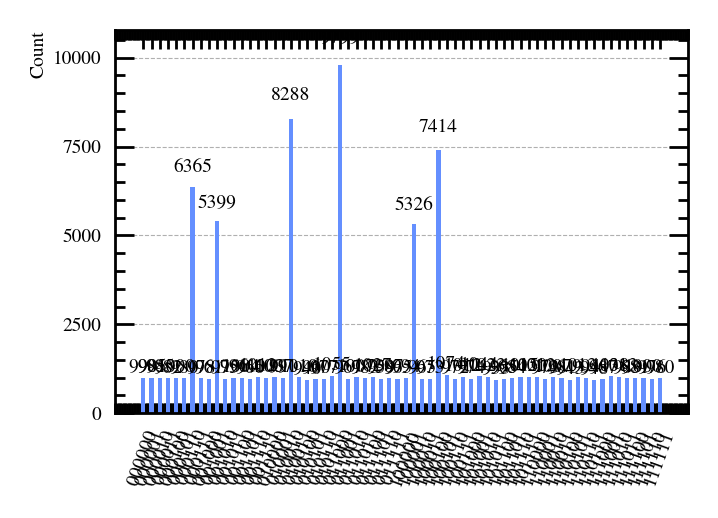

In [135]:
plot_histogram(counts)

In [137]:
max(counts, key=counts.get)

'011000'

In [110]:
n_qubit = 18
n_matching = 6
grover_circuit = QuantumCircuit(n_qubit, n_matching)
grover_circuit.reset(range(0, 18))
grover_circuit = initialize_s(grover_circuit, n_qubit, n_matching)
grover_circuit.x([14, 15, 16])
for i in range(1):
    #1.249   1/10  9/10
    #1.1071   2/10  8/10
    #0.99116   3/10  7/10
    #0.88608   4/10  6/10
    #0.7854   5/10
    #0.68472   6/10  4/10
    #0.57964   7/10  3/10
    #0.46365   8/10  2/10
    #0.32175   9/10  1/10
    #0         10/10  0
    
    grover_circuit = rotate_a1(grover_circuit, n_qubit, 0.68472) # 6
    grover_circuit = rotate_a2(grover_circuit, n_qubit, 1.249)  #
    grover_circuit = rotate_a3(grover_circuit, n_qubit, 0.57964)
    grover_circuit = rotate_b1(grover_circuit, n_qubit, 0.99116)
    grover_circuit = rotate_b2(grover_circuit, n_qubit, 0.88608)
    grover_circuit = rotate_b3(grover_circuit, n_qubit, 0.46365)
    grover_circuit = rotate_c1(grover_circuit, n_qubit, 1.1071)
    grover_circuit = rotate_c2(grover_circuit, n_qubit, 0.32175)
    grover_circuit = rotate_c3(grover_circuit, n_qubit, 0.7854)
    grover_circuit = violate_state(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node2(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node3(grover_circuit, n_qubit)
    grover_circuit = compare_node2_node3(grover_circuit, n_qubit)
    grover_circuit.barrier([8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([7, 8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([6, 7, 8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([5, 6, 7, 8, 9, 10, 11, 12, 13])
    #grover_circuit.barrier([7, 8, 9, 10, 11, 12, 13, 14, 15])
    #grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
    grover_circuit.x([10, 11, 12])
    grover_circuit.mcx([9, 10, 11, 12, 14, 15, 16], n_qubit-1)
    grover_circuit.x([10, 11, 12])
    grover_circuit.h([n_qubit-1])
    grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit = compare_node2_node3(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node3(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node2(grover_circuit, n_qubit)
    grover_circuit = violate_state(grover_circuit, n_qubit)
    grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit = rotate_c3(grover_circuit, n_qubit, -0.7854)
    grover_circuit = rotate_c2(grover_circuit, n_qubit, -0.32175)
    grover_circuit = rotate_c1(grover_circuit, n_qubit, -1.1071)
    grover_circuit = rotate_b3(grover_circuit, n_qubit, -0.46365)
    grover_circuit = rotate_b2(grover_circuit, n_qubit, -0.88608)
    grover_circuit = rotate_b1(grover_circuit, n_qubit, -0.99116)
    grover_circuit = rotate_a3(grover_circuit, n_qubit, -0.57964)
    grover_circuit = rotate_a2(grover_circuit, n_qubit, -1.249)
    grover_circuit = rotate_a1(grover_circuit, n_qubit, -0.68472)
    grover_circuit = diffuser(grover_circuit, 6, n_qubit)
    grover_circuit.measure([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
    grover_circuit.draw(output='mpl', scale = 1.0, fold = 47, style={'backgroundcolor': '#EEEEEE'}, filename = "weighted3x3circuit.jpeg", plot_barriers = False)
# for i in range(1):
#     #grover_circuit = violate_state(grover_circuit)
#     grover_circuit.append(violate_state(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#     grover_circuit.append(compare_node1_node2(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#     grover_circuit.append(compare_node1_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
#     grover_circuit.append(compare_node2_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#     grover_circuit.x([10, 11, 12])
#     grover_circuit.mcx([9, 10, 11, 12], 13)
#     grover_circuit.x([10, 11, 12])
#     grover_circuit.h([13])
#     grover_circuit.append(compare_node2_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#     grover_circuit.append(compare_node1_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
#     grover_circuit.append(compare_node1_node2(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#     grover_circuit.append(violate_state(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#     grover_circuit.append(diffuser(6), [0, 1, 2, 3, 4, 5])
    

#grover_circuit.draw(output = "mpl")


In [31]:
from qiskit import BasicAer, Aer,execute
sim = Aer.get_backend('aer_simulator_statevector')
sim.set_options(device='CPU')
#sim = Aer.get_backend('aer_simulator')

In [32]:
job = execute(grover_circuit, backend = sim, shots = 100000)

In [33]:
counts = job.result().get_counts()

In [72]:
counts

{'001000': 1317,
 '011010': 1342,
 '011110': 1062,
 '100110': 1452,
 '001111': 819,
 '111010': 1406,
 '000111': 844,
 '110000': 1066,
 '001001': 6589,
 '000001': 1078,
 '110110': 1110,
 '101010': 1722,
 '001010': 1571,
 '111111': 617,
 '100001': 5516,
 '111100': 824,
 '100100': 6437,
 '001101': 862,
 '011000': 5299,
 '001011': 1138,
 '100010': 1648,
 '111110': 1125,
 '110001': 882,
 '101111': 1021,
 '000110': 9157,
 '011011': 922,
 '000100': 1046,
 '110011': 799,
 '101101': 1023,
 '110100': 834,
 '101100': 1219,
 '000011': 1046,
 '000010': 1428,
 '110101': 688,
 '101011': 1334,
 '110111': 603,
 '000000': 1304,
 '100111': 995,
 '011001': 931,
 '111011': 959,
 '100101': 1005,
 '001110': 1282,
 '010001': 800,
 '001100': 1045,
 '111101': 639,
 '100011': 1143,
 '101001': 1368,
 '010111': 602,
 '010010': 6286,
 '111001': 935,
 '000101': 853,
 '101110': 1503,
 '110010': 1274,
 '011100': 741,
 '010110': 1035,
 '011101': 613,
 '101000': 1446,
 '010100': 789,
 '010000': 1034,
 '100000': 1408,
 '

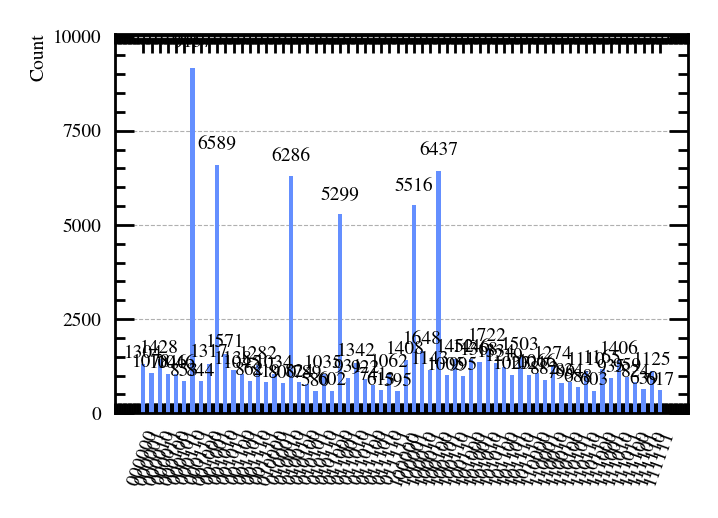

In [34]:
plot_histogram(counts)

In [81]:
sim = sorted(counts, key=counts.get, reverse = True)

In [84]:
a = sim[0]
a[:2]

'00'

In [112]:
def compare(sim, sol, df, step):
    for i in range (6):
        tmp = sim[i]
        a = tmp[:2]
        b = tmp[2:4]
        c = tmp[4:6]
        if (a == '00'):
            a_weight = df[step][0]
        elif (a == '01'):
            a_weight = df[step][1]
        elif (a == '10'):
            a_weight = df[step][2]

        if (b == '00'):
            b_weight = df[step][3]
        elif (b == '01'):
            b_weight = df[step][4]
        elif (b == '10'):
            b_weight = df[step][5]

        if (c == '00'):
            c_weight = df[step][6]
        elif (c == '01'):
            c_weight = df[step][7]
        elif (c == '10'):
            c_weight = df[step][8]

        weight_sum = a_weight + b_weight + c_weight
        print(weight_sum == sol[i])

    

In [79]:
sol = solution(df, 1)

In [80]:
sol

[19, 19, 18, 18, 15, 13]